In [17]:
import pystac
from pystac_client import Client
from shapely.geometry import Point
import rioxarray
from pyproj import CRS
import geopandas as gpd
from folium import Map, TileLayer
import numpy as np
import xarray
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import dask
import rasterio
from rasterio.plot import show
import json
from datetime import datetime
import pandas as pd
import httpx
from shapely.geometry import Polygon, mapping
import pycountry

In [18]:
# Define url and initialize pystac client for fetching data
api_url = "https://earth-search.aws.element84.com/v0"
client = Client.open(api_url)

In [19]:
# Use L2A as it is same as L1C with processing done to remove atmospheric effects
# See: https://forum.step.esa.int/t/clarification-on-difference-between-l1c-and-l2a-data/24940 
collection = "sentinel-s2-l2a-cogs"  # Sentinel-2, Level 2A, COGs

In [20]:
# Get current date, and date within date offset for querying satellite data
current_time = datetime.now()
date_end = current_time.strftime("%Y-%m-%d")
date_offset = pd.Timedelta(days=1) # Set days to 1 to avoid duplicates (for now?)
date_start = (current_time - date_offset).strftime("%Y-%m-%d")
print(date_start, date_end)

2023-02-26 2023-02-27


In [21]:
with open("../app/countries.json", "r") as f:
    country_bounds = json.load(f)

country_bounds

{'aw': {'name': 'Aruba',
  'alpha-2': 'AW',
  'alpha-3': 'ABW',
  'country-code': '533',
  'iso_3166-2': 'ISO 3166-2:AW',
  'region': 'Americas',
  'sub-region': 'Latin America and the Caribbean',
  'intermediate-region': 'Caribbean',
  'region-code': '019',
  'sub-region-code': '419',
  'intermediate-region-code': '029',
  'dial_code': '+297',
  'geonameid': '3577279',
  'capital': 'Oranjestad',
  'currency': 'Guilder',
  'language-codes': 'nl-AW,es,en',
  'area-km2': '193',
  'gdp': '2516000000',
  'boundingBox': {'sw': {'lat': 12.1702998, 'lon': -70.2809842},
   'ne': {'lat': 12.8102998, 'lon': -69.6409842}}},
 'af': {'name': 'Afghanistan',
  'alpha-2': 'AF',
  'alpha-3': 'AFG',
  'country-code': '004',
  'iso_3166-2': 'ISO 3166-2:AF',
  'region': 'Asia',
  'sub-region': 'Southern Asia',
  'intermediate-region': '',
  'region-code': '142',
  'sub-region-code': '034',
  'intermediate-region-code': '',
  'dial_code': '+93',
  'geonameid': '1149361',
  'capital': 'Kabul',
  'currency':

In [131]:
#titiler_endpoint = "https://titiler.xyz"
titiler_endpoint = "http://127.0.0.1:8000"
#'http://127.0.0.1:8000/search/?country=afghanistan'
#url = "https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2019_2573-1085/swissalti3d_2019_2573-1085_0.5_2056_5728.tif"
url = "https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_30TVT_20221112_0_L2A"
r = httpx.get(
    #f"{titiler_endpoint}/cog/tilejson.json",
    f"{titiler_endpoint}/tilejson.json",
    params = {
        #"country": "afghanistan",
        "url": url,
        "assets": ["green", "swir16"],
        #"assets": ["green", "blue"],
        'minzoom': 8,
        'maxzoom': 16,
        "algorithm": "MNDWI",
        #"buffer": 3,
    }
).json()
r
test_url = r['tiles'][0]
deg_y, deg_x, zoom = r['center']
print(test_url)
print(deg_x, deg_y, zoom)

http://127.0.0.1:8000/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=https%3A%2F%2Fearth-search.aws.element84.com%2Fv1%2Fcollections%2Fsentinel-2-l2a%2Fitems%2FS2A_30TVT_20221112_0_L2A&assets=green&assets=swir16&algorithm=MNDWI
47.355901916875645 -3.6033320722850783 8


In [122]:
#titiler_endpoint = "https://titiler.xyz"
#titiler_endpoint = "http://127.0.0.1:8000"
titiler_endpoint = "http://127.0.0.1:8000/search/?country=afghanistan"
#'http://127.0.0.1:8000/search/?country=afghanistan'
#url = "https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2019_2573-1085/swissalti3d_2019_2573-1085_0.5_2056_5728.tif"
#url = "https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_30TVT_20221112_0_L2A"
r = httpx.get(
    #f"{titiler_endpoint}/cog/tilejson.json",
    #f"{titiler_endpoint}/tilejson.json",
    titiler_endpoint,
    follow_redirects=True
    #params = {
    #    "country": "afghanistan",
        #"url": url,
        #"assets": ["green", "swir16"],
        #'minzoom': 8,
        #'maxzoom': 16,
        #"algorithm": "MNDWI",
        #"buffer": 3,
    #}
).json()
#print(dir(r))
print(r)
#print(r)
#test_url = r['tiles'][0]
#deg_y, deg_x, zoom = r['center']
#print(test_url)
#print(deg_x, deg_y, zoom)

{'tilejson': '2.2.0', 'version': '1.0.0', 'scheme': 'xyz', 'tiles': ['http://127.0.0.1:8000/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=https%3A%2F%2Fearth-search.aws.element84.com%2Fv0%2Fcollections%2Fsentinel-s2-l2a-cogs%2Fitems%2FS2B_41SKV_20230227_0_L2A&assets=green&assets=swir16&algorithm=MNDWI'], 'minzoom': 8, 'maxzoom': 14, 'bounds': [59.66760488325661, 35.11107501580061, 60.608434788016304, 36.12100742864502], 'center': [60.138019835636456, 35.61604122222282, 8]}


In [132]:
from pygeotile.point import Point
import numpy as np
import math
import re

def deg2num(lat_deg, lon_deg, zoom):
  lat_rad = math.radians(lat_deg)
  n = 2.0 ** zoom
  xtile = int((lon_deg + 180.0) / 360.0 * n)
  ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
  return (xtile, ytile)

tile_x, tile_y = deg2num(lat_deg=deg_x, lon_deg=deg_y, zoom=zoom)
print(tile_x, tile_y)

125 89


In [133]:
test_url = re.sub('{z}', str(zoom), test_url)
test_url = re.sub('{x}', str(tile_x), test_url)
test_url = re.sub('{y}', str(tile_y), test_url)
print(test_url)

http://127.0.0.1:8000/tiles/WebMercatorQuad/8/125/89@1x?url=https%3A%2F%2Fearth-search.aws.element84.com%2Fv1%2Fcollections%2Fsentinel-2-l2a%2Fitems%2FS2A_30TVT_20221112_0_L2A&assets=green&assets=swir16&algorithm=MNDWI


In [22]:
# Get country bounding box
with open("../app/countries.json", "r") as f:
    country_bounds = json.load(f)

def get_country_bbox(country: str) -> dict[float, float, float, float]:
    # Search for country by name
    common_name_data = pycountry.countries.get(common_name=country)
    name_data = pycountry.countries.get(name=country)

    # Check that country name search returned valid item                                    
    if(not common_name_data and not name_data):
        raise AttributeError("Invalid country name")
    elif(None in [common_name_data, name_data]):
        country_data = common_name_data or name_data
    else:
        country_data = common_name_data

    # Get country code
    #print(country_data)
    country_code = country_data.alpha_2.lower()
    # Extract boundary bvox
    bbox = country_bounds.get(country_code).get("boundingBox")
    left = bbox.get("sw").get("lon")
    bottom = bbox.get("sw").get("lat")
    right = bbox.get("ne").get("lon")
    top = bbox.get("ne").get("lat")
    return [left, bottom, right, top]
    
country_bbox = get_country_bbox("american SamOA")
type(country_bbox[0])

float

In [23]:
# Get country bounding box from https://gist.github.com/graydon/11198540
#'Bolivia', 
# Search for matching data within bounding box
#country_bbox = (-69.5904237535, -22.8729187965, -57.4983711412, -9.76198780685)
search = client.search(
    collections=[collection],
    bbox=country_bbox,
    max_items=500,
    datetime= f"{date_start}/{date_end}",
    query={"eo:cloud_cover":{"lt":10}, "sentinel:valid_cloud_cover": {"eq": True}}, # Select items with lower cloud cover
)

In [24]:
# Get items from query
items = search.get_all_items()
search.matched()

0

In [25]:
for i in items:
    print(i, i.datetime.strftime("%Y-%m-%d"))

In [26]:
items[0].properties

IndexError: list index out of range

In [27]:
grid_cells = list()   
for i in items:
    print(f'Date: {i.datetime}, Grid cell: {i.properties.get("sentinel:utm_zone")} {i.properties.get("sentinel:grid_square")}')
    grid_cells.append(str(i.properties.get("sentinel:utm_zone")) + i.properties.get("sentinel:grid_square"))

In [28]:
# Check duplicates
import collections
collections.Counter(grid_cells).values()

dict_values([])

In [456]:
from threading import Lock

def match_projections(assets: dict[pystac.asset.Asset]) -> dict[xarray.core.dataarray.DataArray]:
    '''
    Desc: Match projections for two raster bands as needed.
    Example: bands = match_projections(test_assets)
    '''
    # Extract bands of interest with the use of Dask chunked arrays
    green_band = rioxarray.open_rasterio(assets["B03"].href, lock=False, chunks = "auto")
    swir_band = rioxarray.open_rasterio(assets["B12"].href, lock=False, chunks = "auto")
    
    # Reproject data to match shapes if unequal
    if(green_band.shape != swir_band.shape):
        print("Reprojecting...")

        if(green_band.shape > swir_band.shape):
            # Use tiled=True to write as chunked GeoTIFF,
            # use Lock() to synchronize threads
            # use compute=False for lazy execution
            green_band = green_band.rio.reproject_match(swir_band, tiled=True, lock=Lock(), compute=False)

        else:
            swir_band = swir_band.rio.reproject_match(green_band, tiled=True, lock=Lock(), compute=False)

    return {"green_band": green_band, "swir_band": swir_band}

def calc_mndwi(bands: dict[xarray.core.dataarray.DataArray]) -> xarray.core.dataarray.DataArray:
    '''
    Desc: Calculate Modified Normalized Difference Water Index (MNDWI) for detecting water
    Example: mndwi = calc_mndwi(bands)
    '''
    green_band = bands.get("green_band")
    swir_band = bands.get("swir_band")

    # Calculate the Modified Normalized Difference Water Index (MNDWI) for detecting water
    mndwi = (green_band - swir_band) / (green_band + swir_band)
    return mndwi

In [457]:
bands = match_projections(test_assets)

Reprojecting...


In [466]:
mndwi_test = calc_mndwi(bands)
#mndwi_test.plot()
type(mndwi_test)

xarray.core.dataarray.DataArray

In [13]:
# We will use the Modified Normalized Difference Water Index (MNDWI) for detecting water
# https://www.space4water.org/taxonomy/term/1246#:~:text=%22The%20Modified%20Normalized%20Difference%20Water,open%20water%20in%20other%20indices.
# "MNDWI = (Green - SWIR) / (Green + SWIR)
# Green = pixel values from the green band
# SWIR = pixel values from the short-wave infrared band"
# First get green and SWIR bands
green_band = rioxarray.open_rasterio(test_assets["B03"].href)
swir_band = rioxarray.open_rasterio(test_assets["B12"].href)

In [424]:
# Check extents and projections
print(green_band.shape)
print(swir_band.shape)
print(green_band.rio.crs)
print(swir_band.rio.crs)

print(green_band.shape == swir_band.shape)

(1, 10980, 10980)
(1, 5490, 5490)
EPSG:32719
EPSG:32719
False


In [15]:
# Reproject green band to match extent of SWIR band
green_matched = green_band.rio.reproject_match(swir_band)
print(green_matched.shape)
print(swir_band.shape)

(1, 5490, 5490)
(1, 5490, 5490)


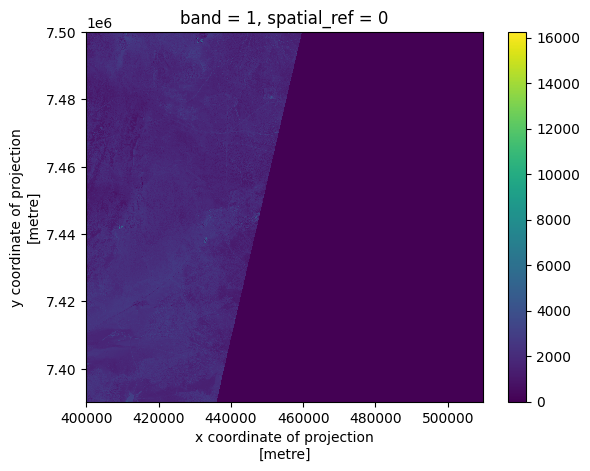

In [16]:
green_matched.plot()

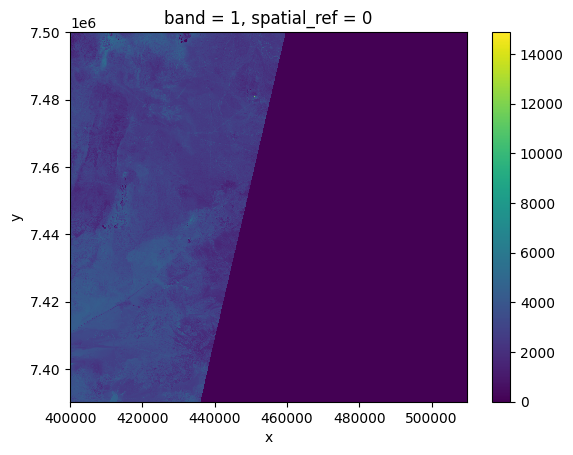

In [17]:
swir_band.plot()

In [18]:
# Calculate MNDWI
#MNDWI = (Green - SWIR) / (Green + SWIR)
mndwi = (green_matched - swir_band) / (green_matched + swir_band)

(array([8.1098182e+07, 3.9414765e+07, 3.7139000e+04, 9.0320000e+03,
        1.2070000e+03, 2.9000000e+01, 4.0000000e+00, 1.0000000e+01,
        4.0000000e+00, 2.8000000e+01]),
 array([    0. ,  1624.8,  3249.6,  4874.4,  6499.2,  8124. ,  9748.8,
        11373.6, 12998.4, 14623.2, 16248. ]),
 <BarContainer object of 10 artists>)

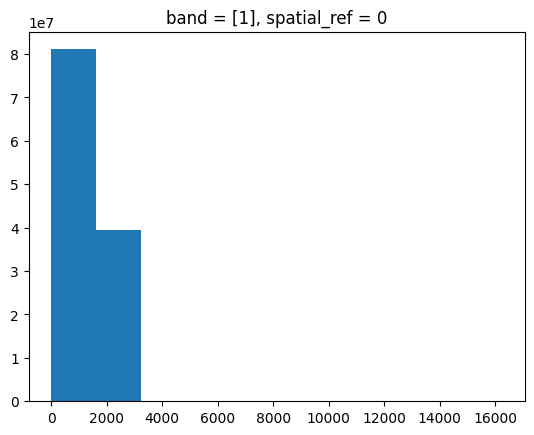

In [19]:
green_band.plot.hist()

(array([2.0275022e+07, 9.8531370e+06, 9.3730000e+03, 2.2490000e+03,
        3.0000000e+02, 7.0000000e+00, 1.0000000e+00, 4.0000000e+00,
        0.0000000e+00, 7.0000000e+00]),
 array([    0. ,  1624.8,  3249.6,  4874.4,  6499.2,  8124. ,  9748.8,
        11373.6, 12998.4, 14623.2, 16248. ]),
 <BarContainer object of 10 artists>)

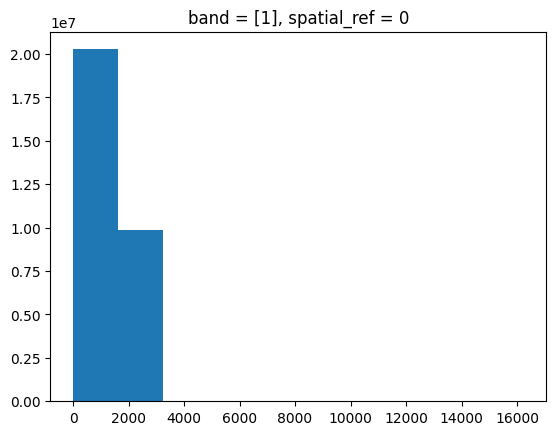

In [20]:
green_matched.plot.hist()

(array([1.7030493e+07, 7.9551830e+06, 5.1067560e+06, 4.7420000e+04,
        1.5600000e+02, 1.7000000e+01, 6.0000000e+00, 1.4000000e+01,
        9.0000000e+00, 4.6000000e+01]),
 array([    0. ,  1488.5,  2977. ,  4465.5,  5954. ,  7442.5,  8931. ,
        10419.5, 11908. , 13396.5, 14885. ]),
 <BarContainer object of 10 artists>)

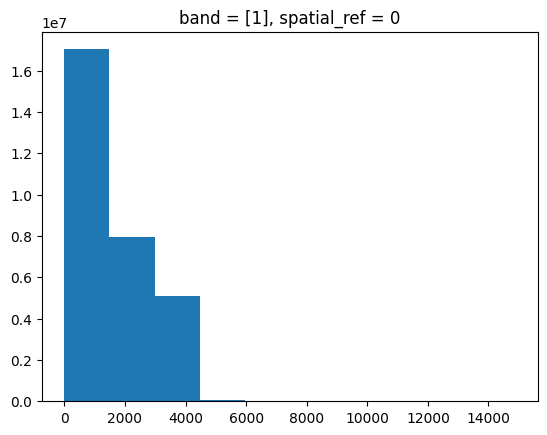

In [21]:
swir_band.plot.hist()

In [22]:
g = green_matched.values[0,0,10]
sw = swir_band.values[0,0,10]
print(g, sw)

1256 2159


In [24]:
#MNDWI = (Green - SWIR) / (Green + SWIR)
#print(g - sw)
#print(g + sw)
#print((g - sw) / (g + sw))

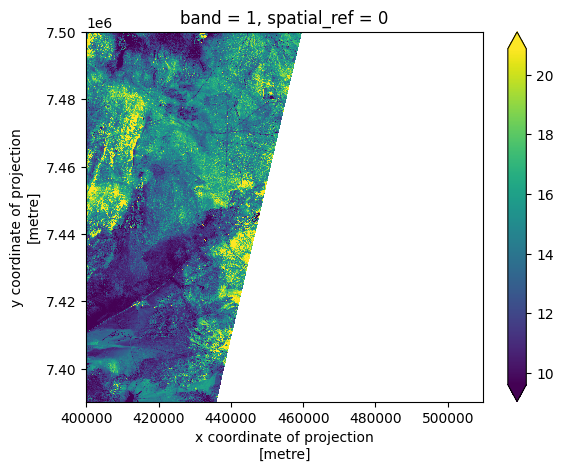

In [25]:
# Plot MNDWI
# Note: use robust=True, otherwise outliers color the picture
mndwi.plot(robust=True)

(array([  19474.,  533068., 8067453., 4122953.,  357715.,   33547.]),
 array([ 0.,  5., 10., 15., 20., 25., 30.]),
 <BarContainer object of 6 artists>)

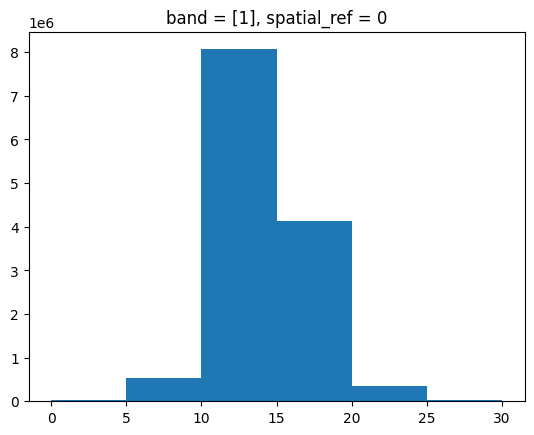

In [79]:
# Plot histogram of selected values - less outliers
#mndwi.plot.hist(bins=(0, 0.2, 0.4, 0.6, 0.8, 1))
mndwi.plot.hist(bins=(0,5,10,15,20,25,30))

In [ ]:
# Interpolate missing values
#mndwi_nonan = mndwi.interpolate_na(dim="x")

In [ ]:
#mndwi_nonan.plot.hist()

In [516]:
# Classify flooded and non-flooded data
# Use 'expert-defined threshold' of 0.3 
# See: https://openaccess.thecvf.com/content_CVPRW_2020/papers/w11/Bonafilia_Sen1Floods11_A_Georeferenced_Dataset_to_Train_and_Test_Deep_Learning_CVPRW_2020_paper.pdf
#class_bins = (0.0, 15)
#mndwi_classified = xarray.apply_ufunc(
#    np.digitize,
#    mndwi,
#    class_bins,
#)
from typing import Union

def classify_raster(class_bins: Union[list[float], tuple[float]], raster) -> xarray.core.dataarray.DataArray:
    
    classified = xarray.apply_ufunc(
        np.digitize,
        raster,
        class_bins,
        dask="allowed")
    
    # Write to disk
    filename = "mndwi_" + datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    filepath = "./" + filename + ".tif"
    classified.rio.to_raster(filepath)

    return classified, filename, filepath

bins = [0.0, 15.0]
mndwi_test_class, filename, filepath = classify_raster(bins, mndwi_test)
type(mndwi_test_class)
print(filepath)

/Users/sashkawarner/repos/flood-data-api/venv/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


./mndwi_2023-02-26T22-26-34.tif


In [486]:
# Save to file
filename = "mndwi_" + datetime.now().strftime("%Y-%m-%d")
mndwi_test_class.rio.to_raster("./" + filename + ".tif")

/Users/sashkawarner/repos/flood-data-api/venv/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


/Users/sashkawarner/repos/flood-data-api/venv/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(array([ 8619995.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0., 21520105.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

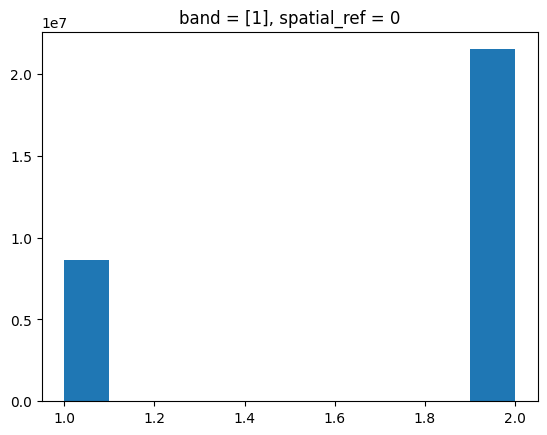

In [470]:
mndwi_test_class.plot.hist()

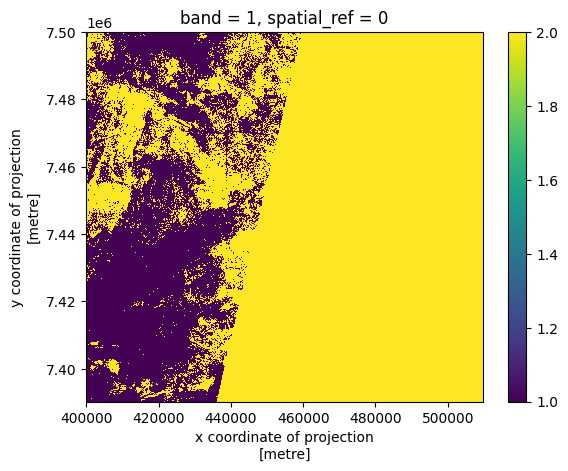

In [82]:
mndwi_classified.plot(robust=True)

In [ ]:
visual = rioxarray.open_rasterio(test_assets["visual"].href)

In [ ]:
visual = visual.load()
visual.plot.imshow(robust=True)

In [ ]:
scl = rioxarray.open_rasterio(test_assets["SCL"].href)
scl = scl.load()
scl.plot.hist()

In [ ]:
scl.squeeze().plot.imshow(levels=range(15), figsize=(12,10))

In [47]:
titiler_endpoint = "http://127.0.0.1:8000"
#url = "https://opendata.digitalglobe.com/events/mauritius-oil-spill/post-event/2020-08-12/105001001F1B5B00/105001001F1B5B00.tif"

#titiler_endpoint = "https://titiler.xyz"  # Developmentseed Demo endpoint. Please be kind.
url = "https://opendata.digitalglobe.com/events/mauritius-oil-spill/post-event/2020-08-12/105001001F1B5B00/105001001F1B5B00.tif"
#item = httpx.get(cog_item).json()
#print(item)
#for it, asset in item["assets"].items():
#    print("Name:", it, "| Format:", asset["type"])

In [48]:
# Fetch File Metadata to get min/max rescaling values (because the file is stored as float32)
r = httpx.get(
    #f"{titiler_endpoint}/cog/info",
    f"{titiler_endpoint}/info",
    params = {
        "url": url,
    }
).json()
print(r)

#bounds = r["bounds"]
#print(r)

{'bounds': [57.664053823239804, -20.55473177712791, 57.84021477996238, -20.25261582755764], 'minzoom': 10, 'maxzoom': 18, 'band_metadata': [['b1', {}], ['b2', {}], ['b3', {}]], 'band_descriptions': [['b1', ''], ['b2', ''], ['b3', '']], 'dtype': 'uint8', 'nodata_type': 'Mask', 'colorinterp': ['red', 'green', 'blue'], 'overviews': [2, 4, 8, 16, 32, 64, 128], 'count': 3, 'width': 38628, 'height': 66247, 'driver': 'GTiff'}


In [214]:
stac_item = "https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_30TVT_20221112_0_L2A"
item = httpx.get(stac_item).json()
#print(item)
for it, asset in item["assets"].items():
    print("Name:", it, "| Format:", asset["type"])

Name: aot | Format: image/tiff; application=geotiff; profile=cloud-optimized
Name: blue | Format: image/tiff; application=geotiff; profile=cloud-optimized
Name: coastal | Format: image/tiff; application=geotiff; profile=cloud-optimized
Name: granule_metadata | Format: application/xml
Name: green | Format: image/tiff; application=geotiff; profile=cloud-optimized
Name: nir | Format: image/tiff; application=geotiff; profile=cloud-optimized
Name: nir08 | Format: image/tiff; application=geotiff; profile=cloud-optimized
Name: nir09 | Format: image/tiff; application=geotiff; profile=cloud-optimized
Name: red | Format: image/tiff; application=geotiff; profile=cloud-optimized
Name: rededge1 | Format: image/tiff; application=geotiff; profile=cloud-optimized
Name: rededge2 | Format: image/tiff; application=geotiff; profile=cloud-optimized
Name: rededge3 | Format: image/tiff; application=geotiff; profile=cloud-optimized
Name: scl | Format: image/tiff; application=geotiff; profile=cloud-optimized
N

In [517]:
#mndwi_classified.rio.to_raster("test.tif")
#catalog = pystac.Catalog(id='flood-data-catalog', description='Flood data catalog.')
#print(pystac.Item.__doc__)
import os

def create_stac_catalog():
    if(os.path.exists("stac")):
        print("exists")
        catalog = pystac.read_file("./stac/catalog.json")
        return catalog
    else:
        catalog = pystac.Catalog(id='flood-data-catalog', description='Flood data catalog.')
        return catalog


create_stac_catalog()

ID: flood-data-catalog
Description: Flood data catalog.
Rel: root
Target:
Media Type: application/json


In [530]:
type(mndwi_test_class)

xarray.core.dataarray.DataArray

In [518]:

def get_bbox_and_footprint(raster: xarray.core.dataarray.DataArray) -> tuple[list, mapping]:
    ''' 
    Desc: Extract bounding box coordinates from raster.clear
    Example: bbox, footprint = get_bbox_and_footprint(your_raster)
    '''
    bounds = raster.rio.bounds()
    bbox = [bounds[0], bounds[1], bounds[2], bounds[3]]
    footprint = Polygon([
        [bounds[0], bounds[1]],
        [bounds[0], bounds[3]],
        [bounds[2], bounds[3]],
        [bounds[2], bounds[1]]
    ])

    return (bbox, mapping(footprint))
    
bbox, footprint = get_bbox_and_footprint(mndwi_test_class)
    
item = pystac.Item(id=filename + "2",
                 geometry=footprint,
                 bbox=bbox,
                 datetime=datetime.utcnow(),
                 properties={})

item

ID: mndwi_2023-02-26T22-26-342
"Bounding Box: [399960.0, 7390240.0, 509760.0, 7500040.0]"
Datetime: 2023-02-27 06:28:56.970208


In [519]:
#assert item.get_parent() is None
catalog.add_item(item)
item.get_parent()
catalog.describe()

* <Catalog id=flood-data-catalog>
  * <Item id=mndwi_2023-02-26>
  * <Item id=mndwi_2023-02-262>
  * <Item id=mndwi_2023-02-26T22-26-342>


In [521]:
item.add_asset(
    key='image',
    asset=pystac.Asset(
        href=filepath, # TODO: get as in memory object?
        media_type=pystac.MediaType.GEOTIFF
    )
)

In [506]:
print(json.dumps(item.to_dict(), indent=4))

{
    "type": "Feature",
    "stac_version": "1.0.0",
    "id": "mndwi_2023-02-262",
    "properties": {
        "datetime": "2023-02-27T06:21:40.362474Z"
    },
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [
                    399960.0,
                    7390240.0
                ],
                [
                    399960.0,
                    7500040.0
                ],
                [
                    509760.0,
                    7500040.0
                ],
                [
                    509760.0,
                    7390240.0
                ],
                [
                    399960.0,
                    7390240.0
                ]
            ]
        ]
    },
    "links": [
        {
            "rel": "root",
            "href": "../catalog.json",
            "type": "application/json"
        },
        {
            "rel": "self",
            "href": "/Users/sashkawarner/repos/flood-data-api

In [522]:
#print(catalog.get_self_href() is None)
catalog.normalize_hrefs('./stac')
catalog.get_self_href()

'/Users/sashkawarner/repos/flood-data-api/scripts/stac/catalog.json'

In [523]:
catalog.save(catalog_type=pystac.CatalogType.SELF_CONTAINED)

In [260]:
item.get_parent()

ID: flood-data-catalog
Description: Flood data catalog.
ID: local-image
"Bounding Box: [399960.0, 7390240.0, 509760.0, 7500040.0]"
Datetime: 2023-02-27 04:20:54.600386
datetime: 2023-02-27T04:20:54.600386Z
href: ./test.tif
Media type: image/tiff; application=geotiff
Owner:
Rel: root
Target:


In [261]:
#with open(catalog.self_href) as f:
#    print(f.read())

with open(item.self_href) as f:
    print(f.read())

{
  "type": "Feature",
  "stac_version": "1.0.0",
  "id": "local-image",
  "properties": {
    "datetime": "2023-02-27T04:20:54.600386Z"
  },
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          399960.0,
          7390240.0
        ],
        [
          399960.0,
          7500040.0
        ],
        [
          509760.0,
          7500040.0
        ],
        [
          509760.0,
          7390240.0
        ],
        [
          399960.0,
          7390240.0
        ]
      ]
    ]
  },
  "links": [
    {
      "rel": "root",
      "href": "../catalog.json",
      "type": "application/json"
    },
    {
      "rel": "parent",
      "href": "../catalog.json",
      "type": "application/json"
    }
  ],
  "assets": {
    "image": {
      "href": "./test.tif",
      "type": "image/tiff; application=geotiff"
    }
  },
  "bbox": [
    399960.0,
    7390240.0,
    509760.0,
    7500040.0
  ],
  "stac_extensions": []
}


In [216]:
# Get Tile URL
r = httpx.get(
    f"{titiler_endpoint}/info",
    params = (
        ("url", stac_item),
        #("url", "file:///Users/sashkawarner/repos/flood-data-api/scripts/stac/"),
        # Get info for multiple assets
        #("assets","blue"), ("assets","green"),
        ("assets","blue")
    )
).json()
print(r)

{'blue': {'bounds': [-4.337134709547373, 46.85817595750231, -2.869529638083867, 47.85370180403547], 'minzoom': 7, 'maxzoom': 13, 'band_metadata': [['b1', {}]], 'band_descriptions': [['b1', '']], 'dtype': 'uint16', 'nodata_type': 'Nodata', 'colorinterp': ['gray'], 'count': 1, 'overviews': [2, 4, 8, 16], 'width': 10980, 'driver': 'GTiff', 'height': 10980, 'nodata_value': 0.0}}


In [217]:
r = httpx.get(
    f"{titiler_endpoint}/tilejson.json",
    params = {
        "url": stac_item,
        "assets": "visual",
        "minzoom": 8,  # By default titiler will use 0
        "maxzoom": 14, # By default titiler will use 24
    }
).json()
print(r)
#bounds = r["bounds"]

{'tilejson': '2.2.0', 'version': '1.0.0', 'scheme': 'xyz', 'tiles': ['http://127.0.0.1:8000/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=https%3A%2F%2Fearth-search.aws.element84.com%2Fv1%2Fcollections%2Fsentinel-2-l2a%2Fitems%2FS2A_30TVT_20221112_0_L2A&assets=visual'], 'minzoom': 8, 'maxzoom': 14, 'bounds': [-4.337121116089946, 46.85818510451771, -2.86954302848021, 47.85361872923358], 'center': [-3.6033320722850783, 47.355901916875645, 8]}


In [263]:
r = httpx.get(
    f"{titiler_endpoint}/tilejson.json",
    params = {
        "url": "../scripts/stac/local-image/local-image.json",
        "assets": "image",
        "minzoom": 8,  # By default titiler will use 0
        "maxzoom": 14, # By default titiler will use 24
    }
).json()
print(r)
#bounds = r["bounds"]

{'tilejson': '2.2.0', 'version': '1.0.0', 'scheme': 'xyz', 'tiles': ['http://127.0.0.1:8000/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=..%2Fscripts%2Fstac%2Flocal-image%2Flocal-image.json&assets=image'], 'minzoom': 8, 'maxzoom': 14, 'bounds': [399960.0, 7390240.0, 509760.0, 7500040.0], 'center': [454860.0, 7445140.0, 8]}


In [ ]:
# Enter in Z for Zoom, X and Y for tile grid cell
#'http://127.0.0.1:8000/tiles/WebMercatorQuad/10/501/358?url=https%3A%2F%2Fearth-search.aws.element84.com%2Fv1%2Fcollections%2Fsentinel-2-l2a%2Fitems%2FS2A_30TVT_20221112_0_L2A&assets=visual'
#http://127.0.0.1:8000/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=..%2Fscripts%2Fstac%2Flocal-image%2Flocal-image.json&assets=image

{'tilejson': '2.2.0', 'version': '1.0.0', 'scheme': 'xyz', 'tiles': ['https://titiler.xyz/cog/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=https%3A%2F%2Fdata.geo.admin.ch%2Fch.swisstopo.swissalti3d%2Fswissalti3d_2019_2573-1085%2Fswissalti3d_2019_2573-1085_0.5_2056_5728.tif&algorithm=hillshade&buffer=3'], 'minzoom': 15, 'maxzoom': 18, 'bounds': [7.090624928537461, 45.91605844102821, 7.1035698381384185, 45.92509300025415], 'center': [7.09709738333794, 45.92057572064118, 15]}


In [ ]:
r = httpx.get(
    f"{titiler_endpoint}/preview",
    params = {
        "url": "../scripts/stac/local-image/local-image.json",
        "assets": "image",
        "minzoom": 8,  # By default titiler will use 0
        "maxzoom": 14, # By default titiler will use 24
    }
).json()
print(r)
#bounds = r["bounds"]

In [77]:
m = Map(
    location=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom_start=10
)

tiles = TileLayer(
    tiles=r["tiles"][0],
    min_zoom=r["minzoom"],
    max_zoom=r["maxzoom"],
    opacity=1,
    attr="ESA"
)
tiles.add_to(m)
m

In [193]:
r = rasterio.open("../scripts/test.tif")

In [194]:
type(r)
#r.rio.bounds()

rasterio.io.DatasetReader

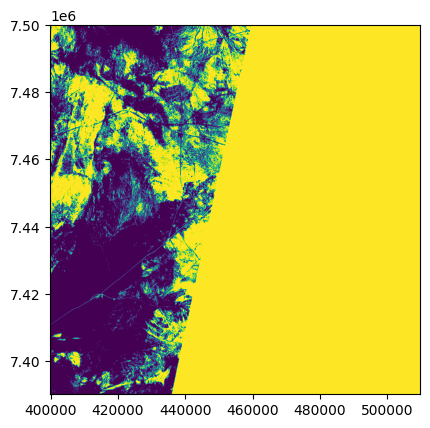

<Axes: >

In [202]:
#array = r.read()
#array
show(r,1)

In [212]:
bounds = [[r.bounds.bottom, r.bounds.left], [r.bounds.top, r.bounds.right]]
overlay = folium.raster_layers.ImageOverlay(r.read(1), bounds)
overlay.add_to(m)


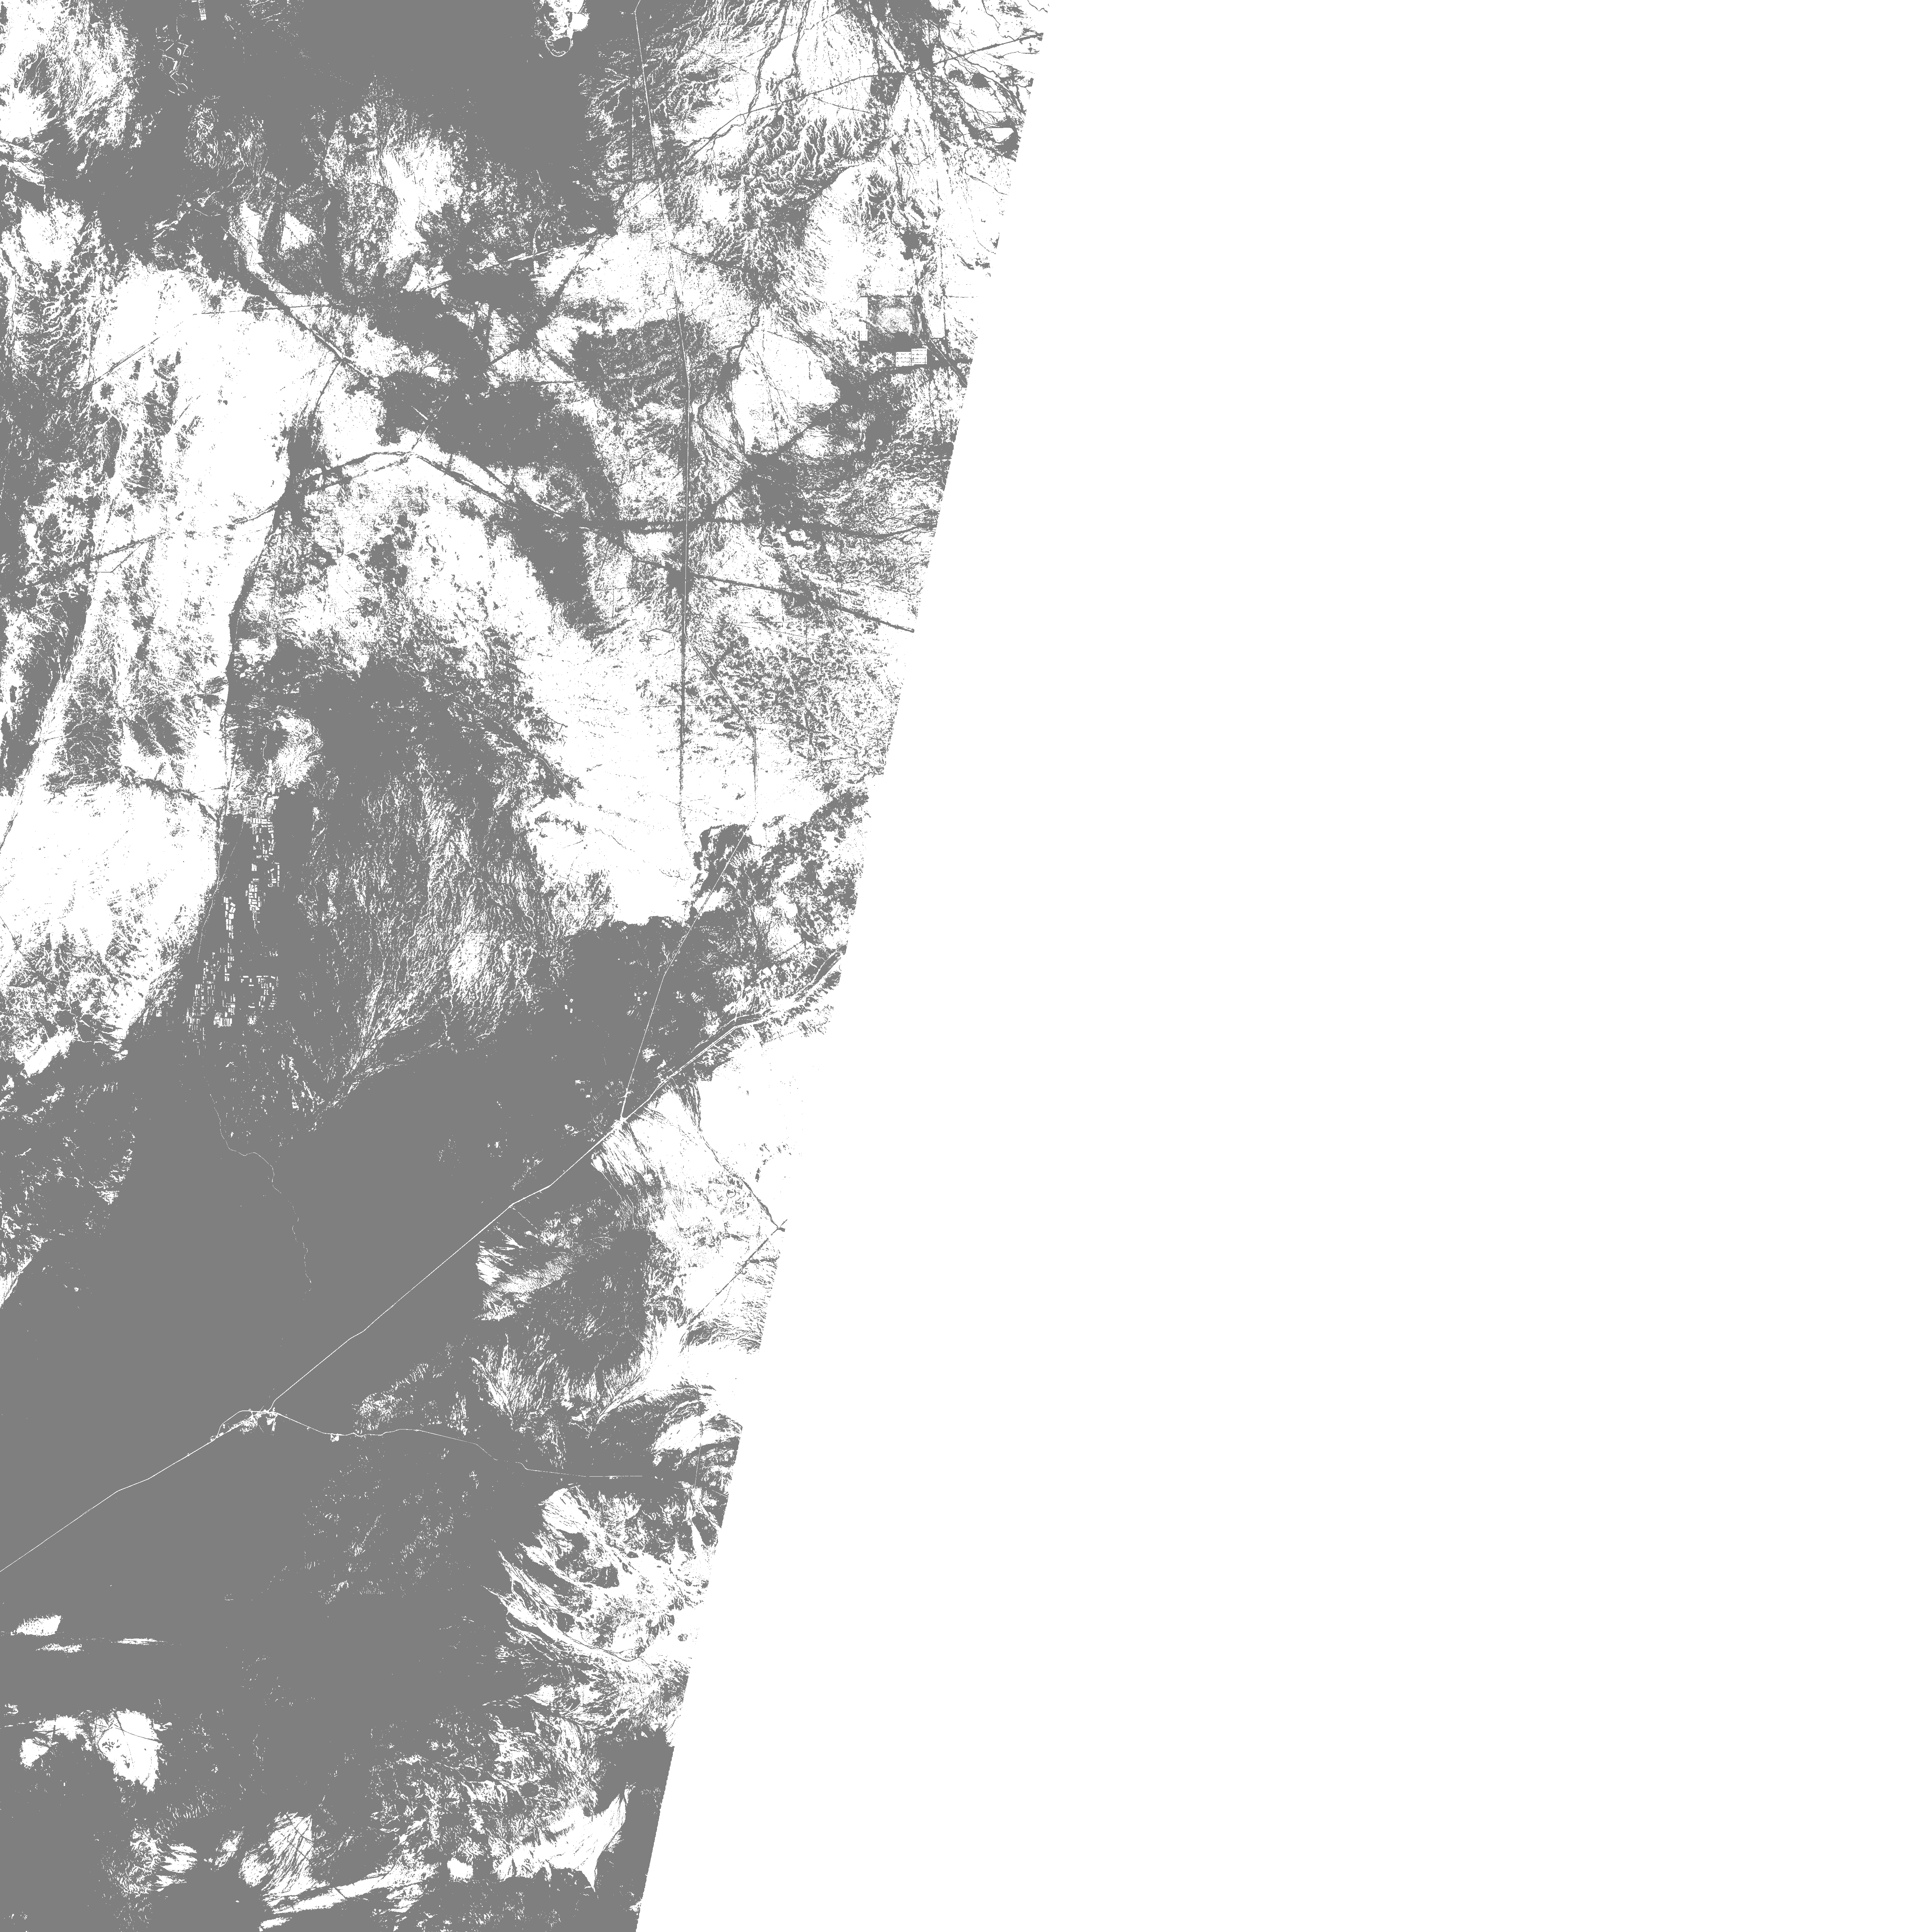

In [213]:
m